In [4]:
import pandas as pd 
import csv
import matplotlib.pyplot as plt
from matplotlib import*
from pandas import *
from numpy.linalg import inv
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import corner
from IPython.display import display, Math
import emcee

In [5]:
Data15=pd.DataFrame(np.loadtxt('SN_data_clean.txt', unpack = False))

SN_data_sim1= pd.read_csv('1SN_data_sim1.csv')
dm_prep=SN_data_sim1['mb1']-SN_data_sim1['m_th']
prep15=Data15[5]-Data15[1]
def dm_cut(df,start,end):
    return df.loc[start:end]

signal_15 = np.matrix(np.loadtxt('cleaned_1500_11.dat.txt', unpack = False))#1500x1500
dm15 = np.matrix(dm_cut(prep15,0,1499))
dmC1=np.matrix(dm_cut(prep15,0,20))


In [6]:
def replaceDiag(matrix, replacementList):
    cp=matrix.copy()
    for i in range(len(replacementList)):
        cp[i,i] = 1/np.sqrt(replacementList[i,0])
    return cp

In [7]:
size=21
I=np.matrix(np.identity(size))
Q=np.matrix(np.loadtxt('n.txt', unpack = False))
N=replaceDiag(I,Q)
def lnlike(theta,dm,signal,size):
    sigma,A,M= theta
    #I=np.matrix(np.identity(size))
    s2=sigma**2
    C=A*signal+s2*N
    #T1=((A*signal)/s2)
    #T2=((A*signal)/s2)**2
    inv_C=np.linalg.inv(C)
    # print(N)
    detC=np.linalg.slogdet(C)
    Dm=dm+np.matrix(M*np.ones(size))
    #print(np.matmul(inv_C,np.transpose(Dm)).shape)
    #print(.5*np.matmul(np.transpose(Dm),np.matmul(inv_C,Dm)))
    return ((-.5*detC[1])-(.5*np.matmul(Dm,np.matmul(inv_C,np.transpose(Dm)))))[0,0]

In [8]:
SCut1=signal_15[:21,:21]


In [9]:
def lnprior(theta):#Prior
    sigma,A,M= theta
    if .005 < sigma < 0.3 and -.0009< A < 5 and -1 < M < 1:
        return 0.0
    return -np.inf

def lnprob(theta,dm,signal,size):  #prob
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,dmC1,SCut1,size)

In [10]:
ndim, nwalkers = 3, 50
pos = [[.08,1,0] + [1e-4, 0.301, 0.301]*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(dmC1,SCut1,21))

In [11]:
k=sampler.run_mcmc(pos,1500)

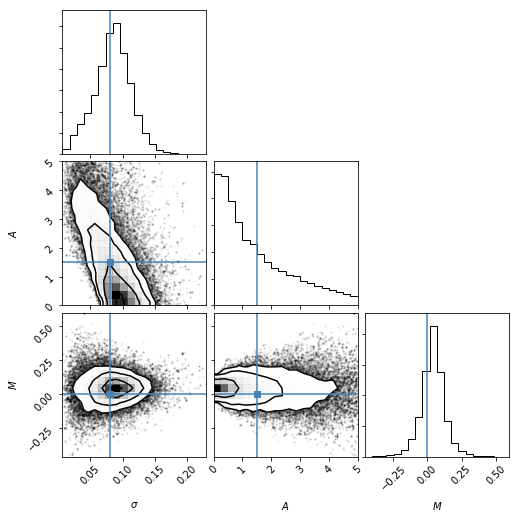

In [12]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$\sigma$", "$A$", "$M$"],
                      truths=[.08, 1.5, 0])
plt.savefig('corner2.png')

In [13]:
labels = ["\sigma", "A", "M"]

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.8f}}}^{{{2:.8f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
# samples = sampler.get_chain(flat=True)
# plt.hist(samples[:, 0], 100, color="k", histtype="step")
# plt.xlabel(r"$\theta_1$")
# plt.ylabel(r"$p(\theta_1)$")
# plt.gca().set_yticks([]);

In [15]:
k[:]

(array([[ 1.15285220e-01,  2.91871911e-01,  2.63255326e-02],
        [ 6.11060890e-02,  4.90417777e-01,  9.18097717e-02],
        [ 9.23528953e-02,  3.53110530e-01,  3.27866753e-02],
        [ 1.15096185e-01,  1.24394791e+00,  4.23804207e-02],
        [ 7.63290931e-02,  2.36337634e+00,  9.58655186e-02],
        [ 8.48989422e-02,  1.84809796e+00,  9.52202659e-02],
        [ 4.19578807e-02,  3.54213044e+00,  2.11196238e-01],
        [ 9.32581700e-02,  2.02160121e-01,  5.81012795e-02],
        [ 1.07986294e-01,  1.85463234e-01,  9.56617395e-02],
        [ 8.63260724e-02,  2.17357499e+00,  2.88104806e-01],
        [ 9.85784720e-02,  9.48461600e-01,  1.06961595e-01],
        [ 1.06768179e-01,  1.42988599e+00,  3.23769064e-02],
        [ 1.34360513e-01,  4.17844092e-01,  3.74462737e-02],
        [ 6.37155634e-02,  5.09690024e-01,  5.20393873e-02],
        [ 8.77100311e-02,  1.53894177e+00,  3.50694315e-02],
        [ 3.87689208e-02,  1.91329929e+00,  1.09276566e-01],
        [ 8.87689187e-02

In [16]:
k[0].shape

(50, 3)

In [17]:
A=k[0][:,1]  #k[2][:][1]

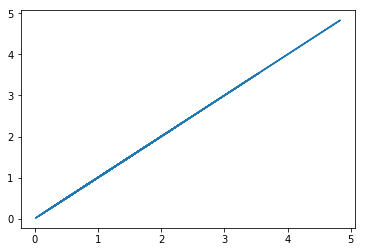

In [18]:
plt.plot(A,A)

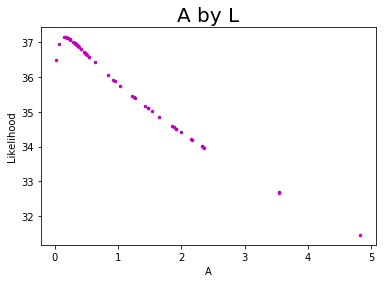

In [19]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step
A=k[0][:,1]
a=[]
for i in A:
    like=lnlike([.0868,i,.0418],dmC1,SCut1,21)
    a.append(like)
plt.plot(A,a,'m.',markersize=5)
plt.xlabel('A')
plt.ylabel('Likelihood')
plt.title('A by L', fontsize=20)
#plt.savefig('First 208Galaxy Location(b,l).png')
plt.show()

In [74]:
z=np.poly1d(np.polyfit(A,a,6))


In [77]:
B=np.arange(-.009,3,.01)

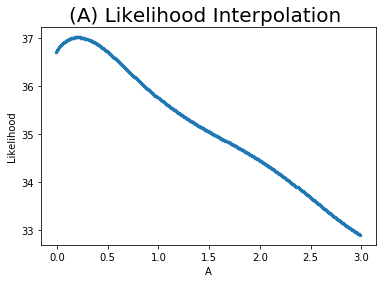

In [78]:
plt.plot(B,z(B),'.',markersize=5)
plt.xlabel('A')
plt.ylabel('Likelihood')
plt.title('(A) Likelihood Interpolation ', fontsize=20)
#plt.savefig('First 208Galaxy Location(b,l).png')
plt.show()

In [23]:
import scipy.integrate as integrate

In [79]:
Atot=integrate.quad(lambda x: z(x), -.009,3 )

In [80]:
Atot[0]*.68

71.83750653975171

In [101]:
integrate.quad(lambda x: z(x), 0,2.00577)

(71.83722033228294, 7.975533603797096e-13)

In [102]:
2.00577-1.0657
#Uppper

0.94007

In [103]:
print(Atot[0]*.34)

35.91875326987586


In [114]:
integrate.quad(lambda x: z(x),0.08136,1.0657)

(35.91826727560039, 3.987728733401185e-13)

In [115]:
1.0657-0.08136 #lower

0.9843400000000001